In [1]:
%run init_notebook.py

In [2]:
import eurostat
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose

from src.utils import save_pd_df

In [3]:
# gdp

In [12]:
data = eurostat.get_data('TIPSAU20', filter_pars={'geo': ['DE']})

In [13]:
gdp = pd.DataFrame(data).T.iloc[4:].copy()
gdp.columns = gdp.iloc[0].values
gdp = gdp.iloc[1:].set_index('geo\TIME_PERIOD').iloc[:, [0]]
gdp.index.name = 'date'
gdp.index = pd.PeriodIndex(gdp.index, freq='Q')

gdp.index = gdp.index.to_timestamp()

In [14]:
for col in gdp:
    x = seasonal_decompose(gdp[col])
    x = hpfilter((x.resid + x.trend).dropna(), lamb=1600/4*4)
    x = x[0].rename(f'gdp_cyc')
    x = (x - x.min()) / (x.max() - x.min()) * .1
    gdp = gdp.join(x)
    
gdp = gdp.dropna()

In [15]:
df = pd.DataFrame(index=pd.period_range(start=gdp.index.min(), end=gdp.index.max(), freq='M', name='date').to_timestamp())
df = df.join(gdp)
df = df.astype(float)

In [16]:
# impute gdp values

In [17]:
idx, ones = gdp.index, (gdp / gdp).values
vals = df.copy().ffill()

In [18]:
df = (((df / df.shift(3)).shift(-3) - 1) / 3).ffill()
df += 1
df.loc[idx] = ones

In [19]:
df = df * vals.ffill()

<AxesSubplot: xlabel='date'>

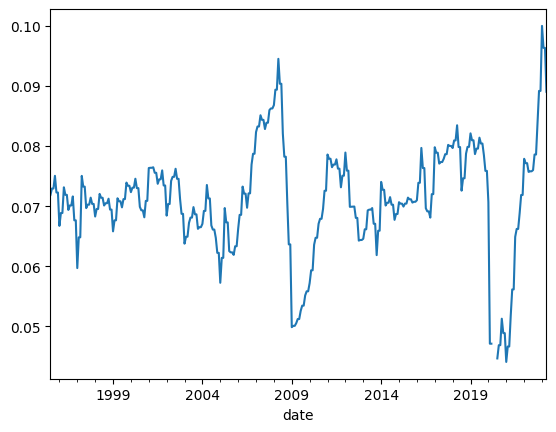

In [20]:
df.gdp_cyc.plot()

In [21]:
# unemployement

In [22]:
data = eurostat.get_data('EI_LMHR_M', filter_pars={'geo': ['DE']})
# ['MED_PS421', 'MED_PS422']

In [23]:
unemp = pd.DataFrame(data).T.iloc[4:].copy()
unemp.columns = unemp.iloc[0].values
unemp = unemp.iloc[1:].set_index('geo\TIME_PERIOD').iloc[:, [0]]
unemp.index.name = 'date'
unemp.index = pd.PeriodIndex(unemp.index, freq='M')

unemp.index = unemp.index.to_timestamp()

In [24]:
unemp['unemp'] = unemp.DE.apply(lambda x: np.nan if x is None else x) / 100
unemp.drop('DE', axis=1, inplace=True)
# unemp = unemp.unemp.dropna()

In [25]:
x = seasonal_decompose(unemp['unemp'].dropna())
x = hpfilter((x.resid + x.trend).dropna(), lamb=1600/4*4)
x = x[0].rename(f'unemp_cyc')
x = (x - x.min()) / (x.max() - x.min()) * .1
unemp = unemp.join(x)

In [26]:
# save

In [32]:
save_pd_df(gdp.join(unemp, how='outer').rename(columns={'DE': 'gdp'}), 'macro.feather')